<a href="https://colab.research.google.com/github/OmarHisham98/Cartoonifying-Line-detection-using-hough-transform/blob/main/CV_assignment_1_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cartoonifying

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


In [ ]:
#This cell is responsible for connecting the notebook with my google drive to access the image
from google.colab import drive
# drive.mount('/content/drive')

def mount():
  drive.flush_and_unmount()
  drive.mount('/content/drive')

mount()



Mounted at /content/drive


## Read image and convert to RGB

<function skimage.io._io.show>

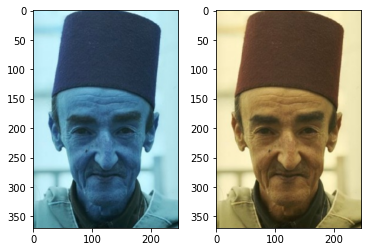

In [ ]:
from skimage import io 
from google.colab.patches import cv2_imshow

# path = '/content/drive/MyDrive/CV_Assignments/face.png'
# img_BGR = cv2.imread(path)
# img_rgb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)


# img_gray_BGR = cv2.cvtColor(img_BGR ,cv2.COLOR_BGR2GRAY) 
# img_gray_rgb = cv2.cvtColor(img_gray_BGR, cv2.COLOR_GRAY2RGB)



# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(img_rgb)
# axarr[1].imshow(img_gray_rgb)

path = '/content/drive/MyDrive/CV_Assignments/face.png'
img_BGR = cv2.imread(path)
img_rgb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
io.imshow_collection([img_BGR,img_rgb])
io.show

##Turning image to greyscale

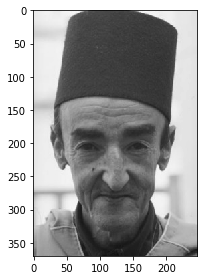

In [ ]:
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
io.imshow(gray)

## Median Filter

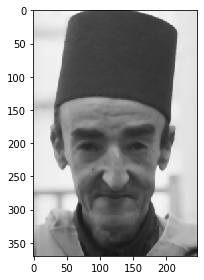

In [ ]:
# blurred_img = cv2.medianBlur(img_gray_rgb, 5)
# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(img_gray_rgb)
# axarr[1].imshow(blurred_img)
blurred_img = cv2.medianBlur(gray, 5)

io.imshow(blurred_img)

## Laplacian Filter

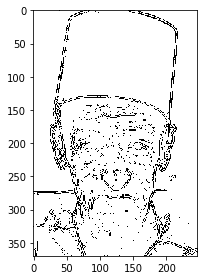

In [ ]:
# laplace_img = cv2.Laplacian(blurred_img, 24, (5,5))
# ret, thresh_img = cv2.threshold(laplace_img, 0, 255, cv2.THRESH_BINARY_INV)
# #thresh_img2 = cv2.adaptiveThreshold(blurred_img, 255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,blockSize=9,C=2)
# f, axarr = plt.subplots(1,3)
# axarr[0].imshow(blurred_img)
# axarr[1].imshow(laplace_img)
# axarr[2].imshow(thresh_img)
laplace_img = cv2.Laplacian(blurred_img, 24, (3,3))
edges = cv2.adaptiveThreshold(laplace_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 3)
io.imshow(edges)


## Bilateral Filter

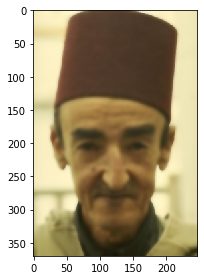

In [ ]:
# img_bilateral = cv2.bilateralFilter(img_rgb, d=9, sigmaColor=9,sigmaSpace=7)
# for i in range(2):
#    img_bilateral = cv2.bilateralFilter(img_bilateral, d=9, sigmaColor=9,sigmaSpace=7)
# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(img_rgb)
# axarr[1].imshow(img_bilateral)
color = cv2.bilateralFilter(img_rgb, 9, 250, 250)
io.imshow(color)

## Merge Edges with bilateral filtered image

<function skimage.io._io.show>

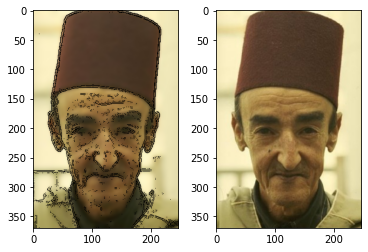

In [ ]:
cartoon = cv2.bitwise_and(color, color, mask=edges)
io.imshow_collection([cartoon,img_rgb])
io.show

# Hough transform






##blurring and canny edges


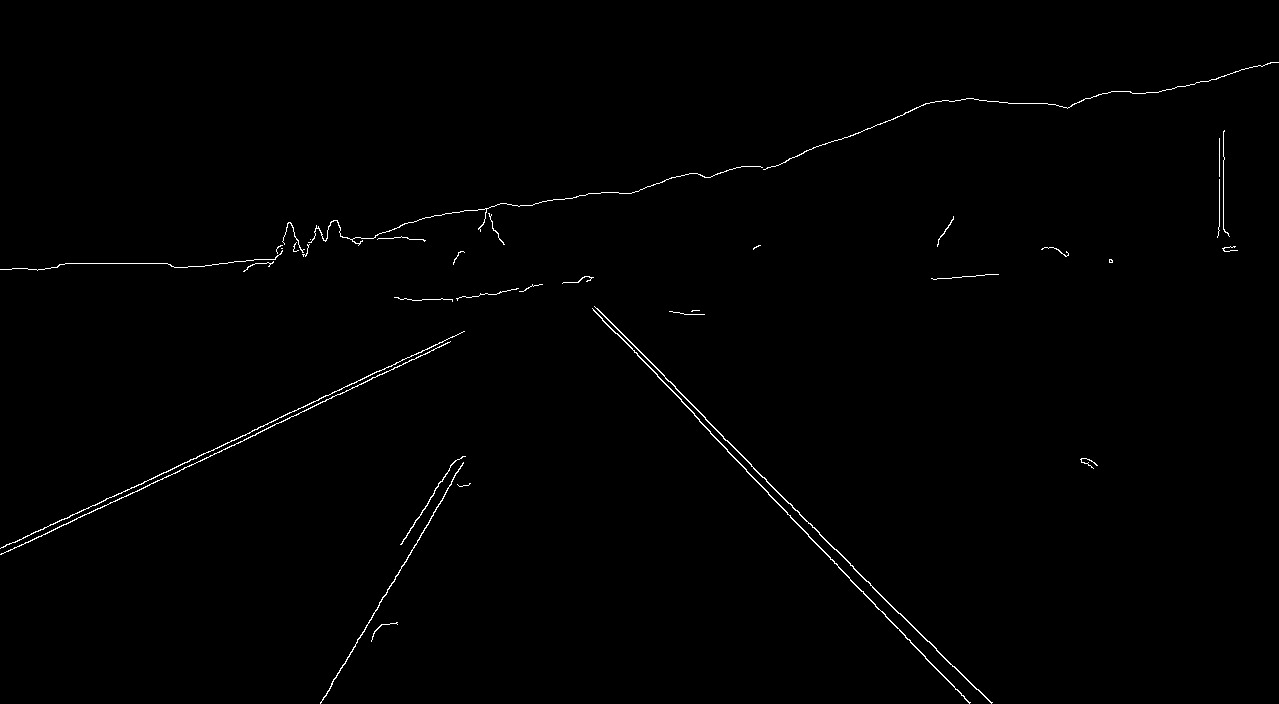

In [ ]:

path_hough = '/content/drive/MyDrive/CV_Assignments/hough.png'
hough_bgr = cv2.imread(path_hough)
hough_rgb = cv2.cvtColor(hough_bgr, cv2.COLOR_BGR2RGB)
hough_gray = cv2.cvtColor(hough_rgb, cv2.COLOR_RGB2GRAY)
hough_blurred=cv2.medianBlur(hough_gray,5)

edged_image= cv2.Canny(image=hough_blurred, threshold1=100, threshold2=200)
cv2_imshow(edged_image)




##determining ROI


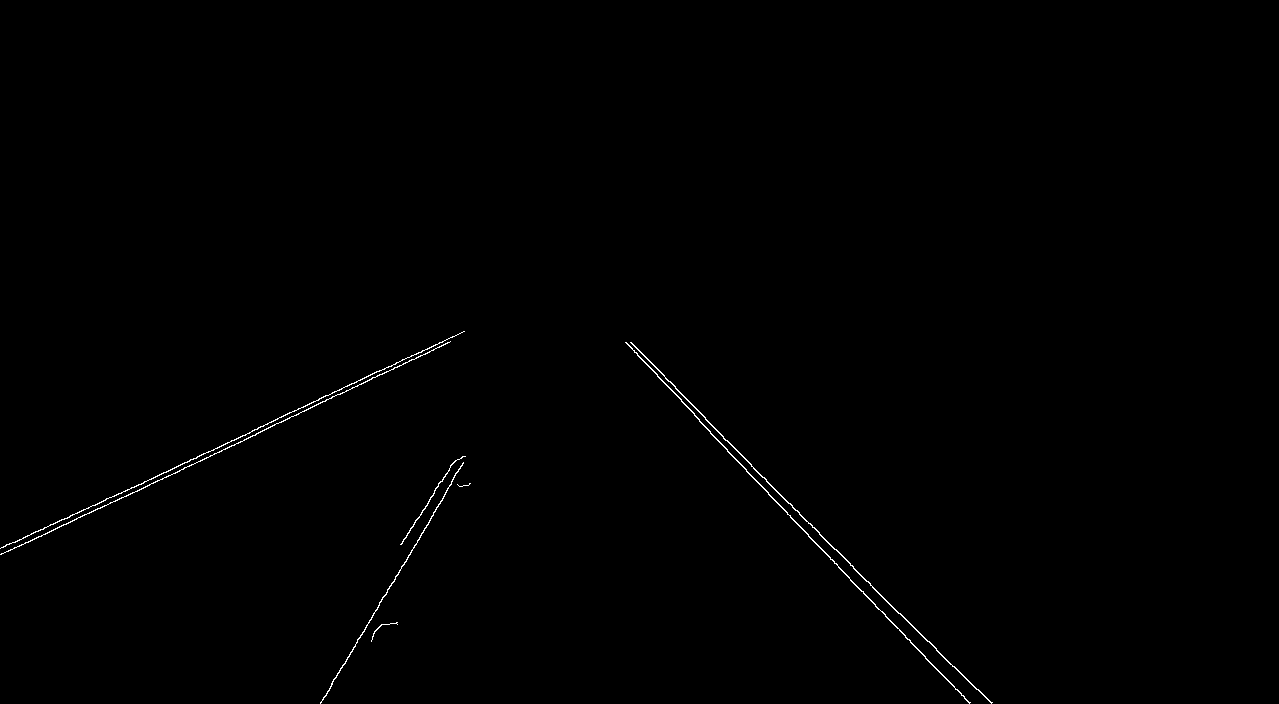

In [ ]:
height, width= edged_image.shape[:2]

ROI= np.array([[(0,height),(0,300),(750,350),(1000,height)]], dtype= np.int64)


mask_image= np.zeros_like(edged_image)


region_of_interest= cv2.fillPoly(mask_image, ROI,255)

roi_image= cv2.bitwise_and(edged_image, region_of_interest)
cv2_imshow(roi_image)


##Hough transform


In [ ]:
def hough_transform(img):
  thetas = np.deg2rad(np.arange(0, 180))
  width, height = img.shape
  diag_len = np.ceil(np.sqrt(width * width + height * height))   # max_dist
  diag_len=int(diag_len)
  # print(type(diag_len))
  rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

  # Cache some resuable values
  cos_t = np.cos(thetas)
  sin_t = np.sin(thetas)
  num_thetas = len(thetas)

  # Hough accumulator array of theta vs rho
  accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
  y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

  # Vote in the hough accumulator
  for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]

    for t_idx in range(num_thetas):
      # Calculate rho. diag_len is added for a positive index
      rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
      accumulator[rho, t_idx] += 1

  return accumulator, thetas, rhos

##get local maxima for hough peaks

In [ ]:
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    ''' A function that returns the indicies of the accumulator array H that
        correspond to a local maxima.  If threshold is active all values less
        than this value will be ignored, if neighborhood_size is greater than
        (1, 1) this number of indicies around the maximum will be surpessed. '''
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        #test if indiciesm surpass in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0: min_x = 0
        else: min_x = idx_x - (nhood_size/2)
        if ((idx_x + (nhood_size/2) + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + (nhood_size/2) + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0: min_y = 0
        else: min_y = idx_y - (nhood_size/2)
        if ((idx_y + (nhood_size/2) + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + (nhood_size/2) + 1

        # bound each index by the neighborhood size and set all values to 0
        for x in range(int(min_x), int(max_x)):
            for y in range(int(min_y), int(max_y)):
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255

    # return the indicies and the original Hough space with selected points
    return indicies, H

##draw lines on the original picture

In [ ]:

# drawing the lines from the Hough Accumulatorlines using OpevCV cv2.line
def hough_lines_draw(img, indicies, rhos, thetas):
    ''' A function that takes indicies a rhos table and thetas table and draws
        lines on the input images that correspond to these values. '''
    for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (255, 255, 0), 2)

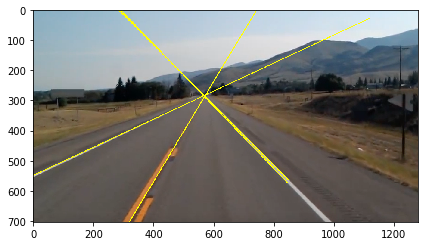

In [ ]:
accumulator, theta_values, rho_values = hough_transform(roi_image)

indicies, H = hough_peaks(accumulator, 3, nhood_size=20) # find peaks
hough_lines_draw(hough_rgb, indicies, rho_values, theta_values)
io.imshow(hough_rgb)